In [361]:
import math

import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
import os
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy

from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
import scipy

In [363]:

def replace_dermis_pixel_with_ring(obj): #obj is a boolean object
        obj_dilate = ndimage.binary_dilation(obj).astype('int')
        ring = obj_dilate - np.array(obj).astype('int')

        labeled_ring = derm * ring
        if not (np.sum(labeled_ring) == 0):
            count = np.bincount(np.ndarray.flatten(labeled_ring))
            replace_val = np.argmax(count[1:] ) + 1
            [x,y] = np.where(obj)
            derm[x,y] = replace_val



In [364]:
#use collagen to define dermis
# 1. extract collagen(class=10) from DLmask
# 2. remove small object and fill holes in collagen to make it a single connected body
# 3. find epidermal-dermis junction using maximum of the binary in y-axis
# 4. remove any pixels that are not epidermis above the epidermal-dermis junction
# 5. iterate each class to replace any potentially wrong pixel to correct class
    #hair foliical: adj pixel look at window

In [365]:
#read deeplab crop
dlcropsrc = r'\\fatherserverdw\kyuex\analysis output\datadst\20220929\dlcrop'

In [366]:
img_name = '2022-06-07 14.37.19sec1.png'
#"2022-06-07 14.34.59sec1.png"

In [367]:
#1. remove small object and fill holes in collagen to make it a single connected body
#10x
dl = Image.open(os.path.join(dlcropsrc, img_name))

In [368]:

dl_arr = np.array(dl)
dl_arr[dl_arr == 12] = 0
col = (dl_arr == 10) #collagen

In [369]:
#2.remove small object and fill holes in collagen to make it a single connected body

minTA = 60000
minTAhole = 10000 #is this too much?

#resize to expedite
(width, height) = (dl.width // 10, dl.height // 10)
collagen = Image.fromarray(col).resize((width, height), resample=0)

collagen= closing(collagen, square(3))  # 13sec
collagen= remove_small_objects(collagen, min_size=minTA, connectivity=2)  # 6sec
collagen = remove_small_holes(collagen , area_threshold=minTAhole).astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(collagen .astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
collagen = cv2.dilate(opening, kernel, iterations=3)
collagen = cv2.dilate(opening, kernel, iterations=3)

#resize back
collagen = Image.fromarray(collagen).resize((dl.width, dl.height),resample=0)
collagen_arr = np.array(collagen)

In [370]:
#3. find epidermal-dermis junction
[xt,yt] = np.where(collagen_arr)

#we actually want to find the minimum x-coordinate (because this image is weirdly oriented)
unique_y = np.unique(yt)
min_x = [np.amin(np.where(collagen_arr[:,y])) for y in unique_y]
thresh = 800 #i'm not sure that this will work with every image. TODO: change
hist, bins = np.histogram(min_x)
#get the value range to remove (note: this doesnt contain last element in bins
remove_bins = [b for h,b in zip(hist,bins) if h < thresh ]

#new junction, remove parts with low frequency in histogram,use remove_bins[0] because it represents where the junction begins to drop
#TODO: need to change this to be more robust, what if the junction drops in the middle,
new_junction_x  = [x for x in min_x if x < np.round(remove_bins[0].astype("uint32"))]
new_junction_y = list(range(len(new_junction_x)))

In [393]:
#2: correct anything that is miss classified in epi
#get new contour
import cv2

collagen_tmp = deepcopy(collagen_arr)
junction_offset = 750

for x,y in zip( new_junction_x, new_junction_y):
    collagen_tmp[np.max(new_junction_x) + junction_offset:, y] = 0

collagen_tmp[:, np.max(new_junction_y):] = 0

max_cx = max(new_junction_x)
max_cy = max(new_junction_y)

collagen_tmp = ndimage.binary_fill_holes(collagen_tmp).astype(collagen_tmp.dtype)

contours, hierarchy = cv2.findContours(collagen_tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [395]:

img = np.zeros((9746, 11162))
cv2.drawContours(img, contours, -1, (255,0,0), 1) #100

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [397]:

#(x1,y1) = (contours[0][0][0][0], contours[0][0][0][1])
#(x2,y2) = (contours[0][-1][0][0], contours[0][-1][0][1])
#cv2.line(img,(x1,y1),(x2,y2),(255,0,0), 1)
cv2.fillPoly(img,contours,(255,0,0))
junction_mask = np.array(img)

In [401]:

img1= img.astype(bool)
img1[max_cx + 1:, :] = 0
[cx,cy] = np.where(img1)


In [403]:
 # epidermis-dermisjunction is not accurate, extend the junction by 750 pix
#epi = deepcopy(dl_arr)
#for x,y in zip(cx,cy):
    #epi[x + junction_offset:, y] = 0

#epi[:,np.max(y)+1:] = 0

epi = deepcopy(dl_arr)
epi[:,np.max(y)+1:] = 0
epi[np.max(x)+1:,:] = 0
[x,y] = np.where(junction_mask)
epi[x+junction_offset,y] = 0

In [404]:
#iterate through epi and replace value with 1 or 2, ignore 0 and 12
window_size = 20

for x in range(np.max(cx)):
    for y in range(np.max(cy)):
        if not (epi[x,y] == 0 or epi[x,y] == 1 or epi[x,y] == 2 or epi[x,y] == 12 or epi[x,y] == 10 ): #it can have some 10 collagen in junction??????

            #question: is it better to do a window search or dilate and use the ring to calculate
            #replace pixel value with 1 or 2
            window_shape = [(x -  window_size) if (x -  window_size) >= 0 else 0,
                      (x + window_size) , y +  window_size,(y -  window_size) if (y - window_size) >=0 else 0] #L,R,T,B

            window = epi[window_shape[0]:window_shape[1], window_shape[3]:window_shape[2]]
            #check pixel values in window
            count1 = np.sum([window == 1])
            count2 = np.sum([window == 2])

            if(count1 >= count2):
                epi[x,y] = 1
            elif (count1 < count2):
                epi[x,y] = 2





In [405]:
#initialize new_dl_arr and make changes to it, do not modify dl_arr
new_dl_arr = deepcopy(dl_arr)

In [406]:
#change new_dl_arr based on new epi
[xt,yt] = np.where(epi ==1)
new_dl_arr[xt,yt] = 1

[xt,yt] = np.where(epi ==2)
new_dl_arr[xt,yt] = 2


In [407]:
#initialize mask for dermis
derm= deepcopy(new_dl_arr)

In [408]:
[x,y] = np.where(epi)
derm[x,y] = 0

In [409]:
#seperate out dermis based on epidermis and dermis junction
#for x,y in zip(cx,cy):
    #derm[0:x + junction_offset, y] = 0 #add 7000 because some parts below the junction is actually still epidermis
    #TODO: do we need to readdress the epidermis as well?

In [410]:
#used for comparison, DO NOT MODIFY derm_original
derm_original = deepcopy(derm)

In [413]:
#replace any 1, 2 in dermis
derm1 = (derm == 1)  #replace by 3
derm2 = (derm == 2)  #replace by 4

In [414]:
if(np.sum(derm1) !=0):
    #replace with 3
    [x,y] = np.where(derm1)
    derm[x,y] = 3

if(np.sum(derm2) !=0):
    #replace with 4
    [x,y] = np.where(derm2)
    derm[x,y] = 4

In [415]:
#3 should have nothing else in it,should be touching four
#todo: take another look at this
derm3 = (derm == 3)

if not np.sum(derm3) == 0:
    derm3 = ndimage.binary_fill_holes(derm3).astype(int)

    #dilate derm3 to create a ring around derm3, check if the rings contain 4
    #if not, remove everything in that ring

    label_derm = label(derm3)


    #this step eliminates any 3 not touching 4
    for i in np.unique(label_derm)[1:]: #0 is background
        ring =  ndimage.binary_dilation(label_derm == i).astype('bool')
        ring = ring * derm

        tmp = (ring) & (derm == 4) #check if 3 is touching 4

        if np.sum(tmp) == 0:
            #TODO: change pixel value to the majority of the ring
            replace_dermis_pixel_with_ring(label_derm == i)

        else:
            [x,y] = np.where(label_derm == i)
            derm[x,y] = 3




In [416]:
# pass in individual follicle object, not the entire mask
def is_follicle(obj,id):
    #too small
    #not round
    if(np.sum(obj.area) < thres_derm4_area):
        return False

    #if it's not too small,check shape
    x,y,w,h = cv2.boundingRect(props[id].coords)
    rect_area = w*h
    extent = obj.area / rect_area
    if(extent > round_threshold):
        return False


    return True

In [417]:
#4 should be big enough, should only have 3 and 6 inside
#how big: above 2000px (above 20 cells)
thres_derm4_area = 2000
round_threshold = 0.9

#smooth derm4
derm4 = (derm == 4)
derm4 = cv2.morphologyEx(derm4.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # use the same kernel as collagen


In [418]:

if not np.sum(derm4) == 0:
    labels = label(derm4)
    props = regionprops(labels)
    # fill hair follicle to create query points
    # query ogDLmask to see if non3|6 exists

    for id, prop in enumerate(props): #id must +1
        if not is_follicle(prop,id):
            #replace using ring
            prop_dilate = ndimage.binary_dilation(labels == (id+1)).astype('bool')
            ring = prop_dilate ^ (labels == (id+1))
            labeled_ring = ring * derm
            count = np.bincount(np.ndarray.flatten(labeled_ring))
            replace_val = np.argmax(count[:])  # could replace with zero??
            [x,y] = np.where(labels == (id+1)) #error
            derm[x,y] = replace_val

        else: #check if 4 only has 3 and 6 inside
            filled_prob = ndimage.binary_fill_holes(labels == (id+1)).astype(int)
            valuesinhair = derm * filled_prob

            thingstoremove = (valuesinhair!=3) | (valuesinhair!=6) | (valuesinhair!=4)

            if(np.sum(thingstoremove.astype('int')) != 0): #TODO: fix!!!!!!this doesn't work
                replace_dermis_pixel_with_ring(thingstoremove)

In [419]:
#write a logic that determines if an object is follicle
#logic includes (size, shape)
# first determine the minimum size of hair follicle
#shape can be measured using scikit.measure.regionprops or cv2 contour properties
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
# https://docs.opencv.org/4.x/d1/d32/tutorial_py_contour_properties.html
#write function that replace a selected object with adjacent pixels

In [420]:
#5 should not have anything inside it, 5 should only touch 12 , 10
thres_derm5_area = 2000
derm5 = (derm == 5)

derm5 = ndimage.binary_fill_holes(derm5).astype(int) #fill 5, don't forget to update derm

labels = label(derm5)
props = regionprops(labels)

In [425]:

for id, prop in enumerate(props): #id must +1
    if prop.area < thres_derm5_area:
        #replace using ring
        replace_dermis_pixel_with_ring(labels == (id+1))



    else: # 5 must not have anything inside, 5 should only touch 12 (which is 0) ,10
        prop_dilate = ndimage.binary_dilation(labels == (id+1)).astype('bool')
        ring = prop_dilate ^ (labels == (id+1))
        labeled_ring = ring * derm


        replace_dict = {8:5, 11:0, 9:10} #replace pixel 8 with 5, ...

         #change 8 to 5, 11 to 0 (12), and 9 to 10
        for key in replace_dict:
            label_key = label(derm == key)
            [xk,yk] = np.where(labeled_ring == key)
            if not (len(xk) == 0): #i.e. if xk is not empty list
                [x,y] = [xk[0],yk[0]]
                to_change_lb = label_key[x,y]
                to_change_area = (label_key==to_change_lb)
                [cx,cy] = np.where(to_change_area)
                derm[cx,cy] = replace_dict[key]

In [426]:
#6 oilgland, 7 sweatgland, 8 nerve, 9 bloodvessel should not contain  any other class within it
to_fill_id = [6,7,8,9]
for id in to_fill_id:
    if(np.sum(derm==id) != 0):
        tmp_derm =  ndimage.binary_fill_holes((derm == id)).astype(int)
        [x,y] = np.where(tmp_derm)
        derm[x,y] = id

In [427]:
[x,y] = np.where(derm==0)
derm[x,y] = 12 #12 is white

[x,y] = np.where(epi == 0)
epi[x,y] = 12 #12 is white

In [428]:
#put dermis on top of epi
final_img = deepcopy(epi)

#3-12
for i in range(3,12):
    [x,y] = np.where(derm == i)
    final_img[x,y] = i

In [429]:
#Image.fromarray(final_img).save("corrected "+ img_name)

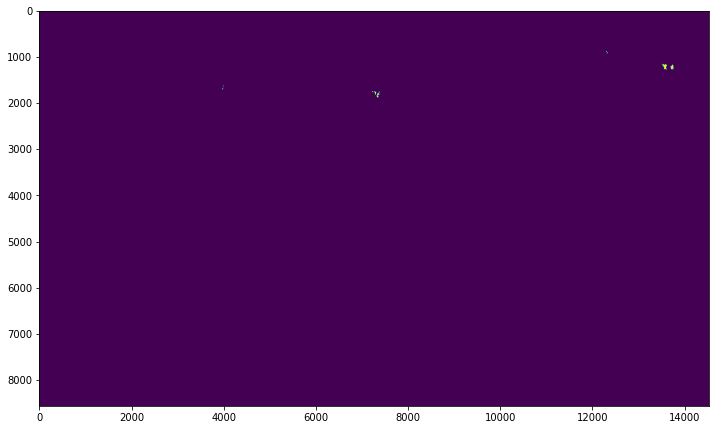

In [438]:
figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)

plt.imshow(final_img==6)

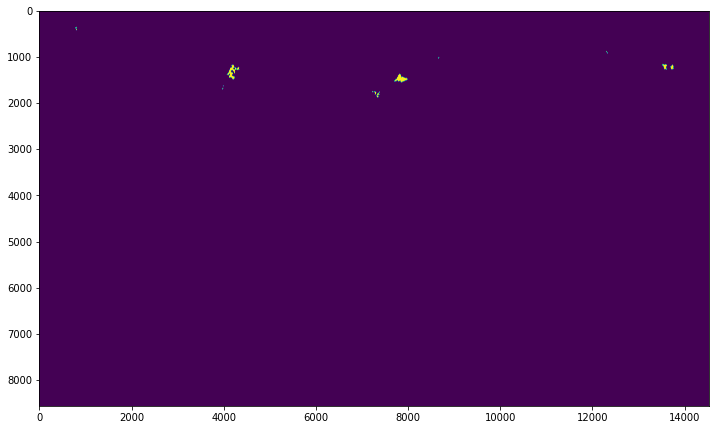

In [439]:

figure_size = plt.gcf().get_size_inches()
factor = 2
plt.gcf().set_size_inches(factor * figure_size)

plt.imshow(dl_arr==6)

In [ ]:
#back from break TODO:
#still something wrong with id4
#some parts of id4 are misclassified as id2
#double check epidermis-dermis junction and how to classify id3 and id4 (or change id1 and id2 into those)
#double check other classes as well